Run first the [setup notebook](./00-setup.ipynb)

# Latent Semantic Indexing

In [1]:
from collections import defaultdict
from gensim import corpora, models
import matplotlib.pyplot as plt

## Let's build the document collection and bag-of-word (bow) representations

In [2]:


documents = [
    "Human machine interface for lab abc computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
    "Graph minors A survey",
]

# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in documents
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

dictionary = corpora.Dictionary(texts)
print(f'vocabulary: {", ".join(dictionary.values())}')


vocabulary: computer, human, interface, response, survey, system, time, user, eps, trees, graph, minors


## Let's create the A matrix (with and without idf-weights)

In [3]:
corpus = [dictionary.doc2bow(text) for text in texts]
print('tf only:')
for i, doc in enumerate(corpus):
    print(f'    document {i+1}: ' + ", ".join([f"{dictionary.get(key)} ({tf})" for (key,tf) in doc]))

# let's create a tf*idf representation
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

print('\ntf-idf:')
for i, doc in enumerate(corpus_tfidf):
    print(f'    document {i+1}: ' + ", ".join([f"{dictionary.get(key)} ({tf_idf})" for (key,tf_idf) in doc]))

tf only:
    document 1: computer (1), human (1), interface (1)
    document 2: computer (1), response (1), survey (1), system (1), time (1), user (1)
    document 3: interface (1), system (1), user (1), eps (1)
    document 4: human (1), system (2), eps (1)
    document 5: response (1), time (1), user (1)
    document 6: trees (1)
    document 7: trees (1), graph (1)
    document 8: trees (1), graph (1), minors (1)
    document 9: survey (1), graph (1), minors (1)

tf-idf:
    document 1: computer (0.5773502691896257), human (0.5773502691896257), interface (0.5773502691896257)
    document 2: computer (0.44424552527467476), response (0.44424552527467476), survey (0.44424552527467476), system (0.3244870206138555), time (0.44424552527467476), user (0.3244870206138555)
    document 3: interface (0.5710059809418182), system (0.4170757362022777), user (0.4170757362022777), eps (0.5710059809418182)
    document 4: human (0.49182558987264147), system (0.7184811607083769), eps (0.491825589872

## Let's apply the SVD transformation and keep 2 topics

In [4]:
# apply LSI transformation without idf weighting
lsi_model = models.LsiModel(corpus, id2word=dictionary, num_topics=3)
corpus_lsi = lsi_model[corpus]
print('tf only:')
for (topic, repr) in lsi_model.print_topics(2):
    print(f'    topic {topic+1}: {repr}')


# apply LSI transformation - keep two topics
lsi_model_tfidf = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
corpus_lsi_tfidf = lsi_model_tfidf[corpus_tfidf]  
print('\ntf-idf:')
for (topic, repr) in lsi_model_tfidf.print_topics(2):
    print(f'    topic {topic+1}: {repr}')

tf only:
    topic 1: 0.644*"system" + 0.404*"user" + 0.301*"eps" + 0.265*"time" + 0.265*"response" + 0.240*"computer" + 0.221*"human" + 0.206*"survey" + 0.198*"interface" + 0.036*"graph"
    topic 2: -0.623*"graph" + -0.490*"trees" + -0.451*"minors" + -0.274*"survey" + 0.167*"system" + 0.141*"eps" + 0.113*"human" + -0.107*"response" + -0.107*"time" + 0.072*"interface"

tf-idf:
    topic 1: 0.703*"trees" + 0.538*"graph" + 0.402*"minors" + 0.187*"survey" + 0.061*"system" + 0.060*"time" + 0.060*"response" + 0.058*"user" + 0.049*"computer" + 0.035*"interface"
    topic 2: -0.460*"system" + -0.373*"user" + -0.332*"eps" + -0.328*"interface" + -0.320*"time" + -0.320*"response" + -0.293*"computer" + -0.280*"human" + -0.171*"survey" + 0.161*"trees"


## Visualization of query (tf only)

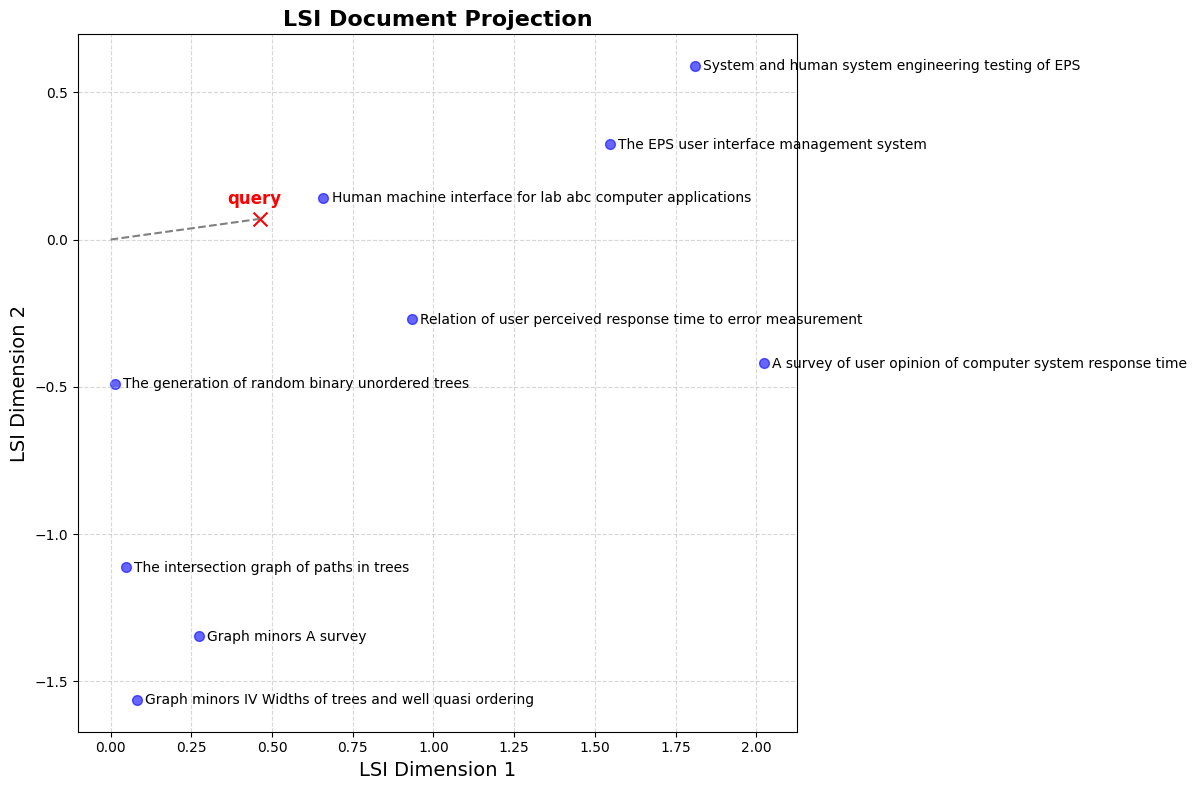

In [12]:
plt.figure(figsize=(12, 8))

# Plot all documents
for doc, text in zip(corpus_lsi, documents):
    plt.scatter(doc[0][1], doc[1][1], color='blue', s=50, alpha=0.6)
    plt.text(doc[0][1]+0.025, doc[1][1]-0.015, text, fontsize=10)

# Plot the query
q = lsi_model[dictionary.doc2bow(['human', 'computer', 'interaction'])]
plt.scatter(q[0][1], q[1][1], color='red', marker='x', s=100)
plt.plot([0, q[0][1]], [0, q[1][1]], linestyle='--', color='gray')
plt.text(q[0][1]-0.1, q[1][1]+0.05, 'query', fontsize=12, fontweight='bold', color='red')

# Add titles and labels
plt.title('LSI Document Projection', fontsize=16, fontweight='bold')
plt.xlabel('LSI Dimension 1', fontsize=14)
plt.ylabel('LSI Dimension 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

## Visualization of query (tf-idf)

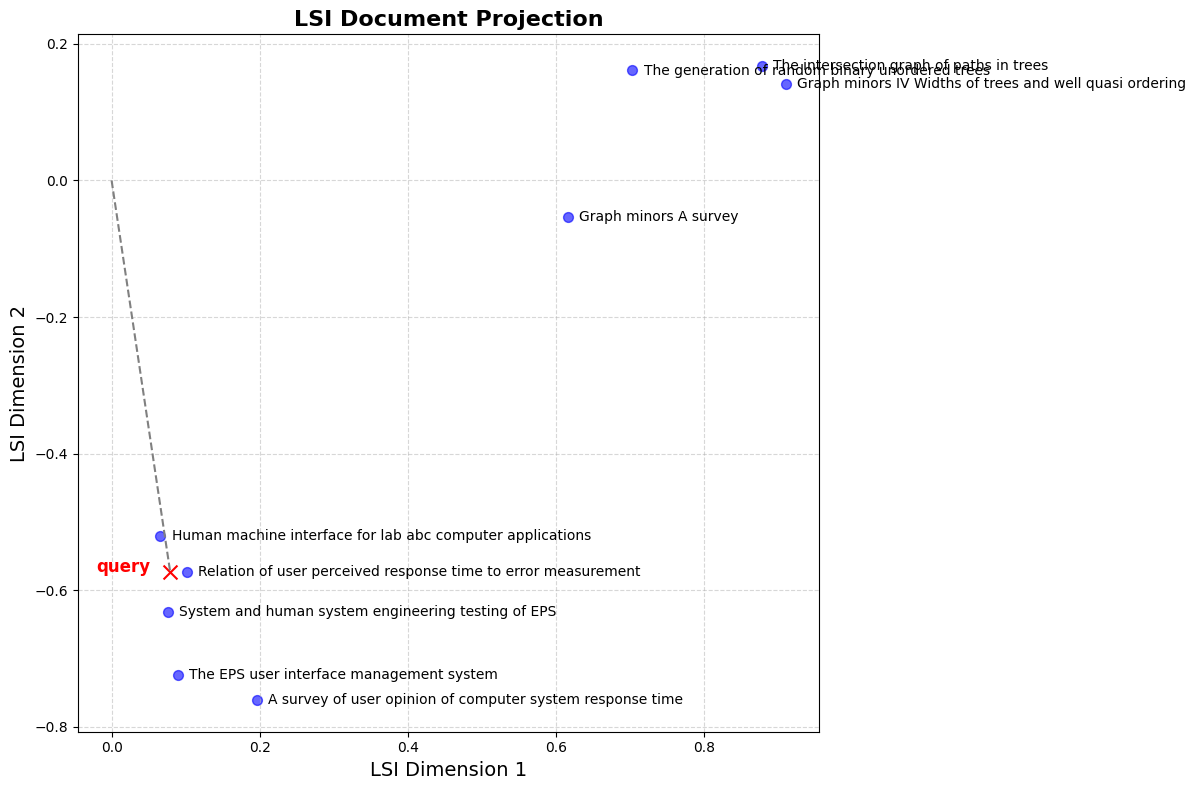

In [10]:
plt.figure(figsize=(12, 8))

# Plot all documents
for doc, text in zip(corpus_lsi_tfidf, documents):
    plt.scatter(doc[0][1], doc[1][1], color='blue', s=50, alpha=0.6)
    plt.text(doc[0][1]+0.015, doc[1][1]-0.006, text, fontsize=10)

# Plot the query
q = lsi_model_tfidf[dictionary.doc2bow(['human', 'computer', 'interaction'])]
plt.scatter(q[0][1], q[1][1], color='red', marker='x', s=100)
plt.plot([0, q[0][1]], [0, q[1][1]], linestyle='--', color='gray')
plt.text(q[0][1]-0.1, q[1][1], 'query', fontsize=12, fontweight='bold', color='red')

# Add titles and labels
plt.title('LSI Document Projection', fontsize=16, fontweight='bold')
plt.xlabel('LSI Dimension 1', fontsize=14)
plt.ylabel('LSI Dimension 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

---